Отже, на останньому етапі ми маємо результат нашої моделі - це ймовірність того, що клієнт банку купить інвестиційний продукт. Я не можу вам надати приклад реальних данних, але вони виглядають досить схоже на логонормальний розподіл, тому ми можемо скористатися сгенерованими випадковими данними.

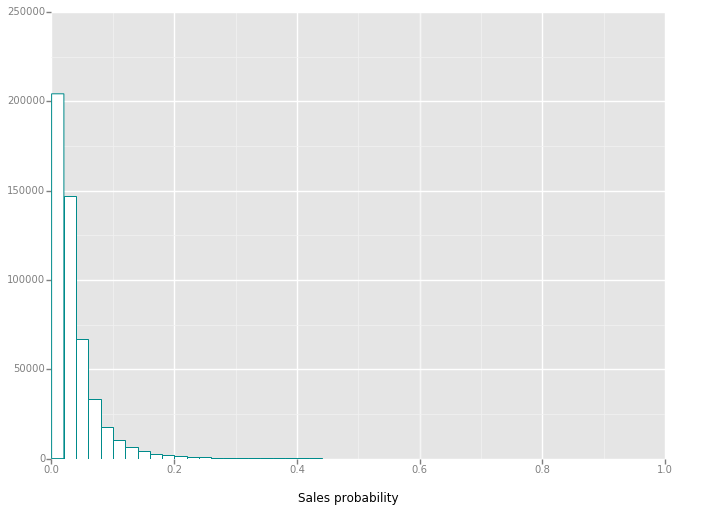

<ggplot: (3697342)>

In [30]:
import pandas as pd
from ggplot import *
%matplotlib inline

data = pd.read_csv('sale_probability.csv')
ggplot(aes(x='Sales probability'), data=pd.DataFrame({ 'Sales probability' : data['probabilities'] })) \
    + geom_histogram(binwidth=0.02, color='darkcyan', fill="white") 

Тепер наша задача обрати таку группу клієнтів для контактів, яка матиме найбільший ефект на продажі за найменших затрат. Іншими словами: зробити меншу кількість дзвінків з найбільшим прибутком. Для цього ми можемо симулювати продажі, використовуючі отримані ймовіності для різних параметрів таргет группи. Ми використаємо парметри min_probability та max_probability, між якими ми будемо обирати клієнтів для контакту.
Ми можемо розрахувати, збільшить чи змешить ймовірність продажів дзвінок клієнту (sales uplift), використовуючі дані про попередні контакти, але ми не маємо цих данних. Тому ми оберемо тривіальну модель uplift: додамо до ймовірності клієнта 0.1, якщо ми йому подзвонили. 

Ще для еффективної моделі нам не вистачає функції прибутку від наших дзвінків. Вона має виглядати приблизно ось так:
$$income=N_{sales}*avg(income_{sale})-N_{contacts}*avg(costs_{contact})$$
Ми не можемо отримати точної фукнції, так як ми не маємо данних про витрати на контакти з клієнтом та не маємо данних про дохід, котрий банк отримує з інвестиційних продуктів. Але для прикладу можна ці параметри вигадати!

In [31]:
import numpy.random as rnd
import numpy as np

result = []
def monte_carlo_coin(probability):
    r = rnd.uniform()
    return int(r < probability)

def income(n_sales, n_contacts):
    avg_income_sale = 10.0
    avg_costs_contact = 2.0
    return n_sales*avg_income_sale - n_contacts*avg_costs_contact

for min_probability in np.arange(0.0,0.9,0.1):
    for max_probability in np.arange(min_probability+0.1,1.0,0.1):
        # uplift
        target_group = data.probabilities.between(min_probability, max_probability)
        data_after_contact = data.copy()
        data_after_contact.ix[target_group, 'probabilities'] = data.ix[target_group].probabilities + 0.1
        
        # simulation
        data_after_contact['sales'] = data_after_contact['probabilities'].apply(monte_carlo_coin)
        
        # results
        sales = data_after_contact['sales'].sum(axis=0)
        calls = target_group.sum(axis=0)
        inc = income(sales, calls)
        result.append((min_probability, max_probability, sales, calls, inc))
        
result = sorted(result, key=lambda x: x[4])
result[-1]

В результаті ми маємо дуже грубо і приблизно пораховану інвестиційно привабливу таргет группу клієнтів за ознакою їх схильності до купівлі продуктів банку.